In [1]:
import pandas as pd

from model_evaluation import evaluate_model
from visualization import plot_tree_based_model, plot_model_accuracy_for_epochs, \
    plot_model_loss_for_epochs, plot_acc_overview, plot_mcc_overview, plot_acc_per_ccp_alpha

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [2]:
# notebook parameters
input_dataset_path = 'data/heart.csv'

#### Functions

In [3]:
heart_df = pd.read_csv(input_dataset_path)
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
# general dataset descriptors
print(f"Input dataset has {heart_df.shape[0]} rows and {heart_df.shape[1]} colums")
print(f"Input dataset consists of {heart_df.drop(columns=['target']).shape[1]} features and 1 target column")

print(f"Target values are: {heart_df['target'].unique()}")
print(f"Input dataset contains {heart_df[heart_df.duplicated()].shape[0]} duplicated rows and {heart_df[heart_df.duplicated()==False].shape[0]} unique rows")

Input dataset has 1025 rows and 14 colums
Input dataset consists of 13 features and 1 target column
Target values are: [0 1]
Input dataset contains 723 duplicated rows and 302 unique rows


In [5]:
# delete all duplicated values within the dataset
heart_df.drop_duplicates(inplace=True)

In [6]:
# divide a heart failure dataset into features and target value sets
x = heart_df.drop(columns=['target'])
y = heart_df['target']

In [7]:
# Select training and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    random_state=12, 
                                                    test_size=0.25)

print(f"Training dataset consists of {x_train.shape[0]} records")
print(f"Test dataset consists of {x_test.shape[0]} records")

Training dataset consists of 226 records
Test dataset consists of 76 records


In [8]:
# some models are sensitive for feature value scale differences
# StandardScaler is used to transform those values into rescaled format, without information loss
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

In [9]:
# Transform target data sets into binary matrix representation of the target values
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test)

### Decision Tree

Model accuracy: 72.36842105263158%
Model precision: 72.72727272727273%
Model recall: 78.04878048780488%
Model F1-score: 0.7529411764705882
Model Matthews Correlation Coefficient (MCC): 0.4418067693151992
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        35
           1       0.73      0.78      0.75        41

    accuracy                           0.72        76
   macro avg       0.72      0.72      0.72        76
weighted avg       0.72      0.72      0.72        76



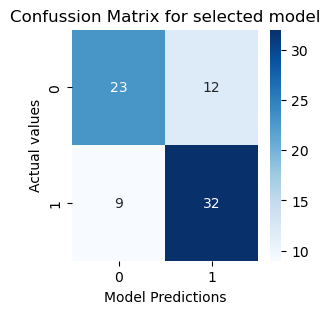

In [10]:
dt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')

dt_model.fit(x_train, y_train)
dt_acc, dt_mcc = evaluate_model(dt_model, x_test=x_test, y_test=y_test)

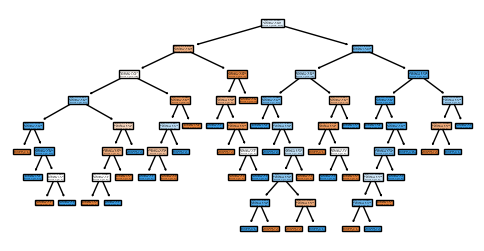

In [11]:
# this model is overfitted
plot_tree_based_model(dt_model)

### Pruning Decision Tree

In [12]:
base_pdt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')
ccp_path = base_pdt_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

In [13]:
pdt_models = []
for ccp_alpha in ccp_alphas:
    pdt_model = DecisionTreeClassifier(random_state=11,
                                       ccp_alpha=ccp_alpha)
    pdt_model.fit(x_train, y_train)

    # add Pruning Decision Tree classifier to list of trees
    pdt_models.append(pdt_model)

In [14]:
print(f"Last tree in list has {pdt_models[-1].tree_.node_count} for cpp_alpha parameter {ccp_alphas[-1]}")

Last tree in list has 1 for cpp_alpha parameter 0.21982887346468272


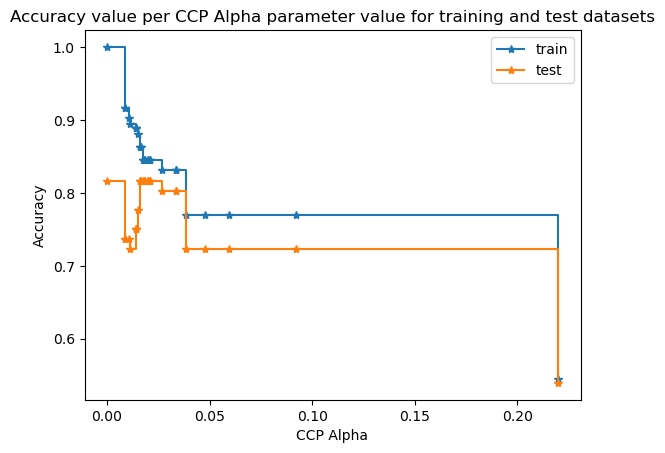

<Figure size 400x200 with 0 Axes>

In [15]:
train_scores = [tree.score(x_train, y_train) for tree in pdt_models]
test_scores = [tree.score(x_test, y_test) for tree in pdt_models]

plot_acc_per_ccp_alpha(ccp_alphas, train_scores, test_scores)

Model accuracy: 72.36842105263158%
Model precision: 75.0%
Model recall: 73.17073170731707%
Model F1-score: 0.7407407407407408
Model Matthews Correlation Coefficient (MCC): 0.4452180646024972
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        35
           1       0.75      0.73      0.74        41

    accuracy                           0.72        76
   macro avg       0.72      0.72      0.72        76
weighted avg       0.72      0.72      0.72        76



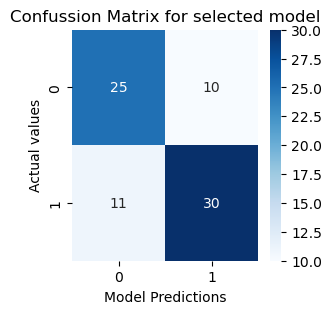

In [16]:
pdt_model = DecisionTreeClassifier(random_state=11,
                             ccp_alpha=0.09, 
                             criterion='entropy')
pdt_model.fit(x_train,y_train)
pdt_acc, pdt_mcc = evaluate_model(pdt_model, x_test=x_test, y_test=y_test)

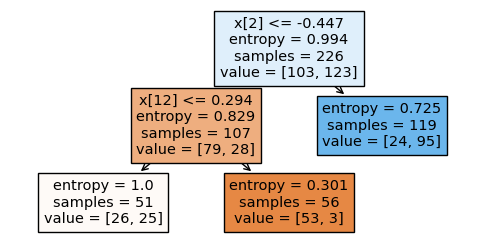

In [17]:
plot_tree_based_model(pdt_model)

### Random Forest

Model accuracy: 80.26315789473685%
Model precision: 79.54545454545455%
Model recall: 85.36585365853658%
Model F1-score: 0.8235294117647058
Model Matthews Correlation Coefficient (MCC): 0.6022079530793161
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        35
           1       0.80      0.85      0.82        41

    accuracy                           0.80        76
   macro avg       0.80      0.80      0.80        76
weighted avg       0.80      0.80      0.80        76



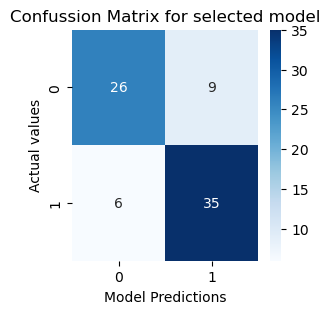

In [18]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  criterion='entropy',
                                  max_features=0.5,
                                  min_samples_leaf=10,
                                  random_state=11,
                                  n_jobs=1)

rf_model.fit(x_train, y_train)
rf_acc, rf_mcc = evaluate_model(rf_model, x_test=x_test, y_test=y_test)

### CNN model

In [19]:
cnn_model = Sequential()
cnn_model.add(Dense(256, 
                    input_dim=13, 
                    activation='relu'))
cnn_model.add(Dense(256, 
                    activation='relu'))
cnn_model.add(Dense(2, 
                    activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(f"CNN model summary: \n{cnn_model.summary()}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 69890 (273.01 KB)
Trainable params: 69890 (273.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CNN model summary: 
None


In [20]:
cnn_model.fit(x_train, 
              y_cat_train, 
              epochs=10, 
              validation_data=(x_test, y_cat_test))

Epoch 1/10
8/8 [==============================] - 1s 51ms/step - loss: 0.5488 - accuracy: 0.7389 - val_loss: 0.4327 - val_accuracy: 0.8026
Epoch 2/10
8/8 [==============================] - 0s 6ms/step - loss: 0.3676 - accuracy: 0.8363 - val_loss: 0.4199 - val_accuracy: 0.8158
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.3338 - accuracy: 0.8451 - val_loss: 0.4093 - val_accuracy: 0.8026
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 0.3046 - accuracy: 0.8673 - val_loss: 0.4276 - val_accuracy: 0.8158
Epoch 5/10
8/8 [==============================] - 0s 6ms/step - loss: 0.2841 - accuracy: 0.8805 - val_loss: 0.4357 - val_accuracy: 0.8158
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.2748 - accuracy: 0.8938 - val_loss: 0.4423 - val_accuracy: 0.8421
Epoch 7/10
8/8 [==============================] - 0s 6ms/step - loss: 0.2580 - accuracy: 0.9071 - val_loss: 0.4475 - val_accuracy: 0.8421
Epoch 8/10
8/8 [=================

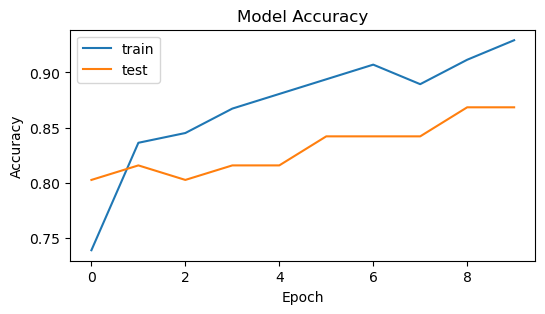

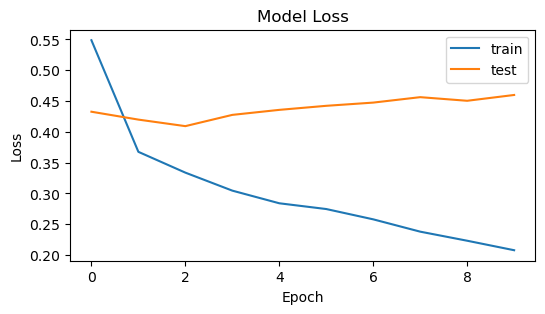

In [21]:
plot_model_accuracy_for_epochs(cnn_model)
plot_model_loss_for_epochs(cnn_model)

In [22]:
print(f"CNN model evaluation after training: {cnn_model.evaluate(x_train, y_cat_train)}")
print (f"CNN model evaluation for test dataset: {cnn_model.evaluate(x_test, y_cat_test)}")

8/8 [==============================] - 0s 2ms/step - loss: 0.1941 - accuracy: 0.9292
CNN model evaluation after training: [0.19413238763809204, 0.9292035102844238]
3/3 [==============================] - 0s 3ms/step - loss: 0.4599 - accuracy: 0.8684
CNN model evaluation for test dataset: [0.4598950743675232, 0.8684210777282715]


3/3 [==============================] - 0s 2ms/step
Model accuracy: 86.8421052631579%
Model precision: 86.04651162790698%
Model recall: 90.2439024390244%
Model F1-score: 0.8809523809523809
Model Matthews Correlation Coefficient (MCC): 0.7351201716570993
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        35
           1       0.86      0.90      0.88        41

    accuracy                           0.87        76
   macro avg       0.87      0.87      0.87        76
weighted avg       0.87      0.87      0.87        76



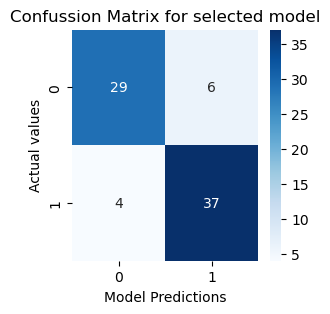

In [23]:
cnn_acc, cnn_mcc = evaluate_model(cnn_model, x_test=x_test, y_test=y_test, is_cnn=True)

### Logistic Regression

Model accuracy: 85.52631578947368%
Model precision: 82.6086956521739%
Model recall: 92.6829268292683%
Model F1-score: 0.8735632183908046
Model Matthews Correlation Coefficient (MCC): 0.7120364525153539
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        35
           1       0.83      0.93      0.87        41

    accuracy                           0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.85        76



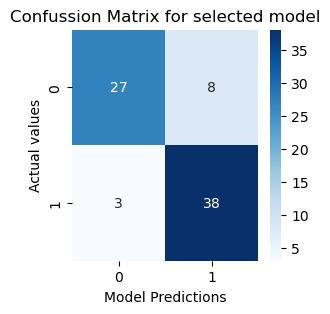

In [24]:
lr_model = LogisticRegression(random_state=0, C=10, penalty='l2')
lr_model.fit(x_train, y_train)
lr_acc, lr_mcc = evaluate_model(lr_model, x_test=x_test, y_test=y_test)

### Support Vector Machine

Model accuracy: 86.8421052631579%
Model precision: 82.97872340425532%
Model recall: 95.1219512195122%
Model F1-score: 0.8863636363636364
Model Matthews Correlation Coefficient (MCC): 0.7414892822055196
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.93      0.77      0.84        35
           1       0.83      0.95      0.89        41

    accuracy                           0.87        76
   macro avg       0.88      0.86      0.87        76
weighted avg       0.88      0.87      0.87        76



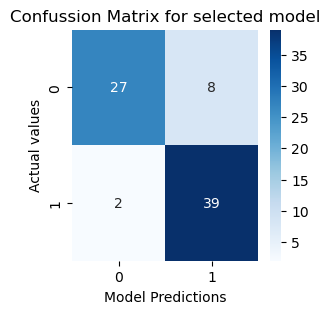

In [25]:
svm_model = SVC(kernel='linear', C=0.3)
svm_model.fit(x_train, y_train)
svm_acc, svm_mcc = evaluate_model(svm_model, x_test=x_test, y_test=y_test)

### K Nearest Neighbours

Model accuracy: 84.21052631578947%
Model precision: 83.72093023255815%
Model recall: 87.8048780487805%
Model F1-score: 0.8571428571428572
Model Matthews Correlation Coefficient (MCC): 0.6818607502596354
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.84      0.88      0.86        41

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



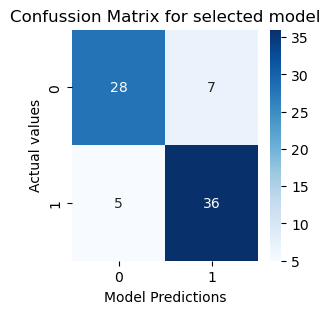

In [26]:
knn_model = KNeighborsClassifier(leaf_size=1, n_neighbors=3)
knn_model.fit(x_train, y_train)
knn_acc, knn_mcc = evaluate_model(knn_model, x_test=x_test, y_test=y_test)

### Comparison of models' results

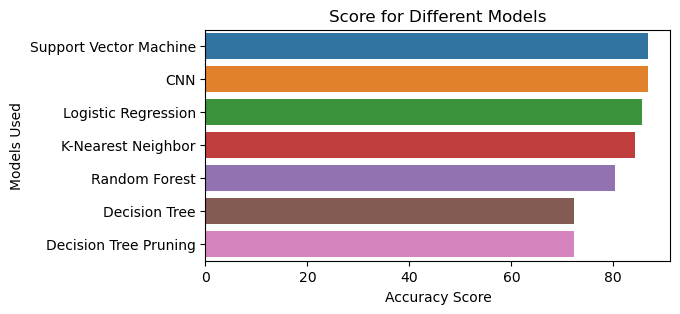

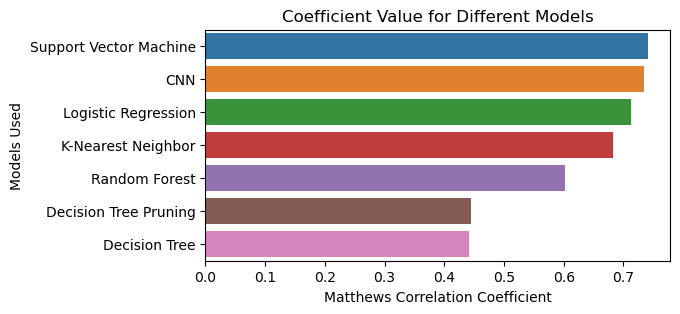

In [27]:
acc_scores = {
    'Decision Tree': dt_acc * 100, 
    'Decision Tree Pruning': pdt_acc * 100, 
    'Random Forest': rf_acc * 100, 
    'Logistic Regression': lr_acc * 100,
    'Support Vector Machine': svm_acc * 100, 
    'K-Nearest Neighbor': knn_acc * 100,
    'CNN': cnn_acc * 100
}

mcc_scores = {
    'Decision Tree': dt_mcc, 
    'Decision Tree Pruning': pdt_mcc, 
    'Random Forest': rf_mcc, 
    'Logistic Regression': lr_mcc,
    'Support Vector Machine': svm_mcc, 
    'K-Nearest Neighbor': knn_mcc,
    'CNN': cnn_mcc
}

plot_acc_overview(acc_scores)
plot_mcc_overview(mcc_scores)